# Group 2 Optical Character Recognition Project Project - Group 2
## Summary
This project is to explore creating a character recognition system utilizing a convolutional neural network
## Completed By:
Aidan MacNichol – 30094369

Bailey Collison – 30133909

David Pozniak – 00324580

Yael Gonzalez - 30247278

In [1]:
# All imports and set up done in the first cell

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from torchvision.transforms import InterpolationMode
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shutil

import re
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"
os.environ['TF_ENABLE_ONEDNN_OPTS'] = "0"

import warnings
warnings.filterwarnings(action='ignore')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('CUDA available', torch.cuda.is_available())
print('CUDA version', torch.version.cuda)
print('cuDNN enabled', torch.backends.cudnn.enabled)
print('cuDNN version', torch.backends.cudnn.version())
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print('Device name:', torch.cuda.get_device_name(0))
print('Device:', device)

batch_size = 1024
image_resize = 28
num_workers = 16

# These are different options of dataset configurations
# "./data/training_data"
# "./data/testing_data" 
# "./data/all_training_data"
# "./data/license_plate_chars" 
train_folder = "./data/training_data"
test_folder = "./data/testing_data" 

# dirs for data mined single license plate chars
tl_train_folder = "./data/license_plate_split_data/train"
tl_test_folder = "./data/license_plate_split_data/test"

nepochs = 1000
early_stopping_patience = 10
min_improve = 0.01
best_loss = float('inf')
PATH = './best_char_model.pth'
TL_PATH = "./best_license_plate_model.pth"

CUDA available True
CUDA version 12.4
cuDNN enabled True
cuDNN version 90100
PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
Device name: NVIDIA GeForce RTX 2080 Ti
Device: cuda:0


In [2]:
# Function to compute dataset statistics (same as mnist example)
def get_dataset_stats(data_loader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data in data_loader:
        images = data[0]
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        nb_samples += batch_samples
    mean /= nb_samples
    std /= nb_samples
    return mean, std
    
# Extract text from file names as well as labels
def read_text_files_with_labels(path):
    texts = []
    labels = []
    class_folders = sorted(os.listdir(path))
    label_map = {class_name: idx for idx, class_name in enumerate(class_folders)}
    for class_name in class_folders:
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            file_names = os.listdir(class_path)
            for file_name in file_names:
                file_path = os.path.join(class_path, file_name)
                if os.path.isfile(file_path):
                    file_name_no_ext, _ = os.path.splitext(file_name)
                    text = file_name_no_ext.replace('_', ' ')
                    texts.append(text)
                    labels.append(class_name) # label_map[class_name]
    return np.array(texts), np.array(labels)
    
# functions to show an image (also same as mnist example)
def imshow(img,stats):
    # when unnormalizing, I had to add extra channels for RGB
    img = img * stats[1].view(-1, 1, 1) + stats[0].view(-1, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

class EarlyStopper:
    def __init__(self, patience=3, min_improve=0.001):
        self.best_val = float('inf')
        self.current_val = float('inf')
        self.patience = patience
        self.min_improve = min_improve
        self.steps_since_last_best = 0
    def __call__(self, val) -> bool:
        """Returns True if training should stop"""
        self.current_val = val
        self._update_best()
        return self.steps_since_last_best >= self.patience
    def _update_best(self):
        """Update best value and patience counter"""
        if self.current_val < (self.best_val - self.min_improve):
            print(f"New best value: {self.current_val:.4f} (improvement > {self.min_improve:.3f})")
            self.best_val = self.current_val
            self.steps_since_last_best = 0
        else:
            self.steps_since_last_best += 1
            print(f"No improvement ({self.steps_since_last_best}/{self.patience})")

# This is used to predict results using the trained model
def predict(model, dataloader, device, classes):
    model = model.to(device)
    model.eval() 
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    predict_loop = tqdm(dataloader, desc="Predicting", leave=False)
    with torch.no_grad(): 
        for data in predict_loop:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            predict_loop.set_postfix({"batch_acc": f"{torch.sum(preds == labels).item()/labels.size(0):.4f}"})
    all_preds = [classes[pred] for pred in all_preds]
    accuracy = 100 * correct / total
    print(f"\nTest Accuracy: {accuracy:.2f}%")
    print(f"Correct: {correct}/{total}")
    return all_preds

In [3]:
# Extract text + lables
text_train, labels_train = read_text_files_with_labels(train_folder)
text_test, labels_test = read_text_files_with_labels(test_folder)

#Initial transform to attain training data stats.
initial_transform = transforms.Compose([
            transforms.Resize((image_resize, image_resize), interpolation=InterpolationMode.BILINEAR), 
            transforms.Grayscale(num_output_channels=1),       
            transforms.ToTensor()])

train_dataset_initial = torchvision.datasets.ImageFolder(root=train_folder, transform=initial_transform)

train_loader_initial = torch.utils.data.DataLoader(train_dataset_initial, batch_size=batch_size, shuffle=True, num_workers=num_workers)

stats = get_dataset_stats(train_loader_initial)

transform = {
    "train": transforms.Compose([
            transforms.Resize((image_resize, image_resize), interpolation=InterpolationMode.BILINEAR),
            # transforms.RandomCrop(image_resize),
            # transforms.RandomHorizontalFlip(),
            # transforms.RandomVerticalFlip(),
            # transforms.ColorJitter(brightness=0.15, contrast=0.15),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((stats[0]), (stats[1]))]),
    "test": transforms.Compose([
            transforms.Resize((image_resize, image_resize)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((stats[0]), (stats[1]))])
}

# Reload the dataset with the new transform
train_dataset = torchvision.datasets.ImageFolder(root=train_folder, transform=transform["train"])

train_set_size = int(0.8 * len(train_dataset))
val_set_size = len(train_dataset) - train_set_size

train_set, val_set = torch.utils.data.random_split(train_dataset, [train_set_size, val_set_size], generator=torch.Generator().manual_seed(0))

# Load test dataset with same transform
test_dataset = torchvision.datasets.ImageFolder(root=test_folder, transform=transform["test"])

# data loaders for training, validation, and test sets
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
valloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

# get classes from folder names
classes = train_dataset.classes
print("Classes:", classes)

Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


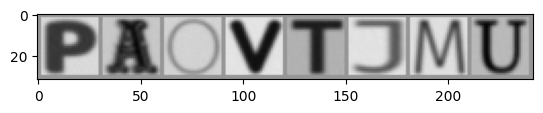

P     A     0     V     T     J     M     U    


In [4]:
# get some random training images and print them
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]), stats)
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

In [5]:
# This is the NN model that we used to train for single char OCR
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64*12*12, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        # Flatten the tensor into a 1D vector
        x = x.view(-1, 64*12*12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

num_classes = len(train_dataset.classes)
print("Number of classes: ", num_classes)

net = Net(num_classes)
net.to(device)

Number of classes:  36


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=36, bias=True)
)

In [6]:
# Required functions to train the model
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9) # Optimizer used for training
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
early_stopper = EarlyStopper(patience=early_stopping_patience, min_improve=min_improve)

In [7]:
# The training and validation loop to train and validate the first single char OCR model.
for epoch in range(nepochs):
    # Training Loop
    train_loss = 0.0
    net.train()
    train_loop = tqdm(trainloader, desc=f"Epoch {epoch + 1}/{nepochs} [Training]", leave=False)
    for i, data in enumerate(train_loop):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_loop.set_postfix({"Train Loss": f"{loss.item():.3f}"})
    avg_train_loss = train_loss / len(trainloader)
    print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.3f},', end=' ')

    # Validation Loop
    net.eval()
    val_loss = 0.0
    val_loop = tqdm(valloader, desc=f"Epoch {epoch + 1}/{nepochs} [Validation]", leave=False)
    with torch.no_grad():
        for i, data in enumerate(val_loop):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_loop.set_postfix({"Val Loss": f"{loss.item():.3f}"})
    avg_val_loss = val_loss / len(valloader)
    print(f'Val Loss: {avg_val_loss:.3f}')

    # Early stopper here.
    if early_stopper(val_loss):
        break
    if early_stopper.steps_since_last_best == 0:
        torch.save(net.state_dict(), PATH)
        
    scheduler.step()
    
print('Finished Training')

Epoch 1, Train Loss: 3.502, 

Val Loss: 3.279
New best value: 16.3925 (improvement > 0.010)


Epoch 2, Train Loss: 2.055, 

Val Loss: 1.008
New best value: 5.0415 (improvement > 0.010)


Epoch 3, Train Loss: 1.099, 

Val Loss: 0.725
New best value: 3.6248 (improvement > 0.010)


Epoch 4, Train Loss: 0.514, 

Val Loss: 0.417
New best value: 2.0834 (improvement > 0.010)


Epoch 5, Train Loss: 0.366, 

Val Loss: 0.361
New best value: 1.8066 (improvement > 0.010)


Epoch 6, Train Loss: 0.312, 

Val Loss: 0.331
New best value: 1.6561 (improvement > 0.010)


Epoch 7, Train Loss: 0.286, 

Val Loss: 0.276
New best value: 1.3811 (improvement > 0.010)


Epoch 8, Train Loss: 0.248, 

Val Loss: 0.288
No improvement (1/10)


Epoch 9, Train Loss: 0.238, 

Val Loss: 0.292
No improvement (2/10)


Epoch 10, Train Loss: 0.215, 

Val Loss: 0.278
No improvement (3/10)


Epoch 11, Train Loss: 0.205, 

Val Loss: 0.248
New best value: 1.2408 (improvement > 0.010)


Epoch 12, Train Loss: 0.200, 

Val Loss: 0.262
No improvement (1/10)


Epoch 13, Train Loss: 0.200, 

Val Loss: 0.236
New best value: 1.1817 (improvement > 0.010)


Epoch 14, Train Loss: 0.183, 

Val Loss: 0.221
New best value: 1.1070 (improvement > 0.010)


Epoch 15, Train Loss: 0.170, 

Val Loss: 0.246
No improvement (1/10)


Epoch 16, Train Loss: 0.163, 

Val Loss: 0.238
No improvement (2/10)


Epoch 17, Train Loss: 0.156, 

Val Loss: 0.221
No improvement (3/10)


Epoch 18, Train Loss: 0.156, 

Val Loss: 0.222
No improvement (4/10)


Epoch 19, Train Loss: 0.145, 

Val Loss: 0.233
No improvement (5/10)


Epoch 20, Train Loss: 0.132, 

Val Loss: 0.221
No improvement (6/10)


Epoch 21, Train Loss: 0.137, 

Val Loss: 0.243
No improvement (7/10)


Epoch 22, Train Loss: 0.133, 

Val Loss: 0.213
New best value: 1.0626 (improvement > 0.010)


Epoch 23, Train Loss: 0.122, 

Val Loss: 0.220
No improvement (1/10)


Epoch 24, Train Loss: 0.110, 

Val Loss: 0.210
New best value: 1.0476 (improvement > 0.010)


Epoch 25, Train Loss: 0.109, 

Val Loss: 0.219
No improvement (1/10)


Epoch 26, Train Loss: 0.103, 

Val Loss: 0.209
No improvement (2/10)


Epoch 27, Train Loss: 0.098, 

Val Loss: 0.229
No improvement (3/10)


Epoch 28, Train Loss: 0.096, 

Val Loss: 0.223
No improvement (4/10)


Epoch 29, Train Loss: 0.089, 

Val Loss: 0.221
No improvement (5/10)


Epoch 30, Train Loss: 0.089, 

Val Loss: 0.269
No improvement (6/10)


Epoch 31, Train Loss: 0.097, 

Val Loss: 0.210
No improvement (7/10)


Epoch 32, Train Loss: 0.085, 

Val Loss: 0.220
No improvement (8/10)


Epoch 33, Train Loss: 0.078, 

Val Loss: 0.245
No improvement (9/10)


Epoch 34, Train Loss: 0.078, 

Val Loss: 0.236
No improvement (10/10)
Finished Training


In [8]:
# Load the best model to be used in the test set
net = Net(num_classes)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

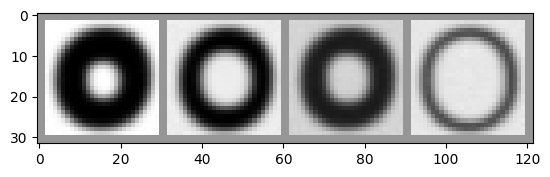

GroundTruth:  0     0     0     0    


In [9]:
dataiter = iter(testloader)
images, labels = next(dataiter)
# print images
imshow(torchvision.utils.make_grid(images[:4]), stats)
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
outputs = net(images)

In [10]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  0     0     0     0    


In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')

Accuracy of the network on the test images: 98.01587301587301 %


In [12]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 96.4 %
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Accuracy for class: 5     is 100.0 %
Accuracy for class: 6     is 100.0 %
Accuracy for class: 7     is 100.0 %
Accuracy for class: 8     is 100.0 %
Accuracy for class: 9     is 100.0 %
Accuracy for class: A     is 100.0 %
Accuracy for class: B     is 100.0 %
Accuracy for class: C     is 100.0 %
Accuracy for class: D     is 100.0 %
Accuracy for class: E     is 100.0 %
Accuracy for class: F     is 100.0 %
Accuracy for class: G     is 100.0 %
Accuracy for class: H     is 100.0 %
Accuracy for class: I     is 100.0 %
Accuracy for class: J     is 100.0 %
Accuracy for class: K     is 100.0 %
Accuracy for class: L     is 100.0 %
Accuracy for class: M     is 100.0 %
Accuracy for class: N     is 100.0 %
Accuracy for class: O     is 39.3 %
Accuracy for class: P     is 100.0 %
Accuracy for class: Q     is 92.9 %
Accu


Test Accuracy: 98.02%
Correct: 988/1008


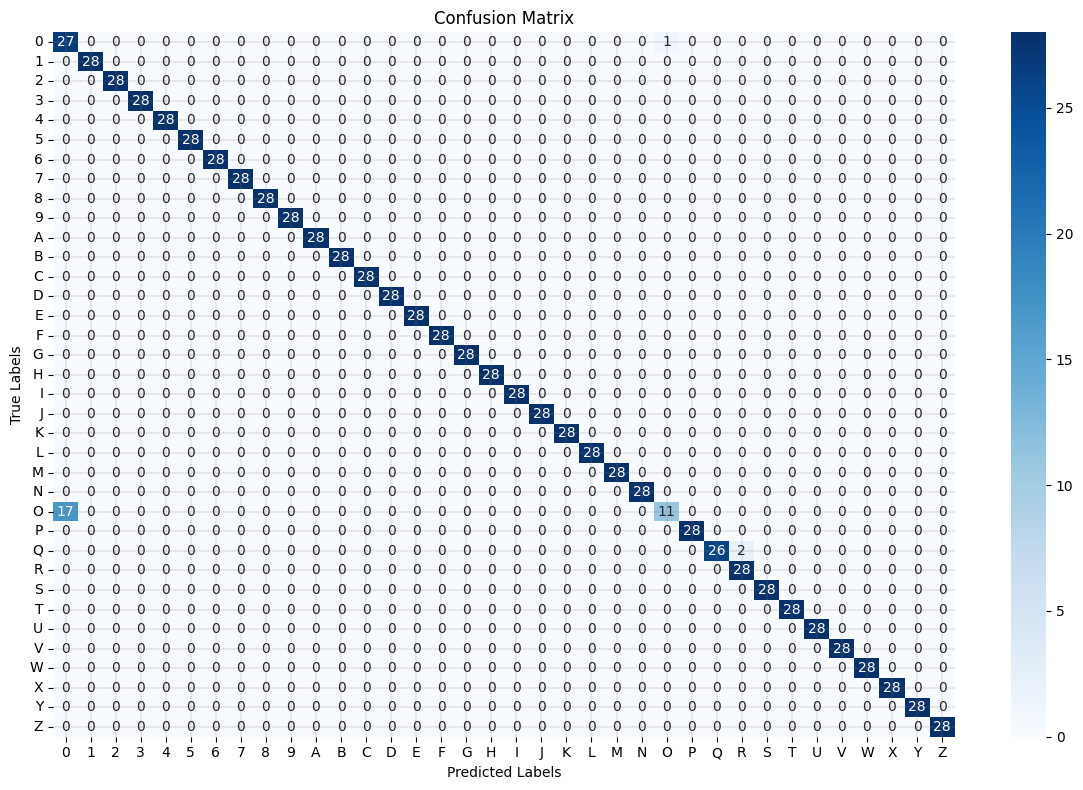

In [13]:
# Evaluation
test_predictions = np.array(predict(net, testloader, device, classes))
    
cm = confusion_matrix(labels_test, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=True, xticklabels=classes, yticklabels=classes)
plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.3)
plt.gca().set_yticklabels(classes, rotation=0)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

# Transfer Learning

## Create Train and Test sets from License Plate Chars data

In [14]:
### NOTE: This should only be ran once. If you dont have the data set split, uncomment and run this.

# # Paths for source and output
# source_dir = "./data/license_plate_chars"
# target_dir = "./data/license_plate_split_data"

# # Ensure target directories exist
# for split in ["train", "test"]:
#     os.makedirs(os.path.join(target_dir, split), exist_ok=True)

# # Process each character folder
# for char in os.listdir(source_dir):
#     char_path = os.path.join(source_dir, char)
#     if not os.path.isdir(char_path):
#         continue  # Skip non-directory files

#     images = os.listdir(char_path)
#     random.shuffle(images)  # Shuffle images

#     num_images = len(images)
#     if num_images < 2:
#         print(f"Skipping '{char}' (not enough images to split)")
#         continue

#     # Ensure at least one image in each split
#     test_count = max(1, int(0.1 * num_images))
#     train_count = num_images - test_count

#     # Create split directories for this character
#     train_path = os.path.join(target_dir, "train", char)
#     test_path = os.path.join(target_dir, "test", char)
#     os.makedirs(train_path, exist_ok=True)
#     os.makedirs(test_path, exist_ok=True)

#     # Copy files
#     for img in images[:train_count]:
#         shutil.copy(os.path.join(char_path, img), os.path.join(train_path, img))
#     for img in images[train_count:]:
#         shutil.copy(os.path.join(char_path, img), os.path.join(test_path, img))

# print("Dataset split complete!")

## Perform the same transformation on the new (license plate) data

In [15]:
## NOTE: When applying transfer learning, the stats from the original model are to be used for normalization, rather then generating new ones on the new data.

# Define transforms with augmentation for training and simple resize for test
transform = {
    "train": transforms.Compose([
        transforms.Resize((image_resize, image_resize), interpolation=InterpolationMode.BILINEAR),
        # transforms.RandomCrop(image_resize),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
        # transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean=stats[0], std=stats[1])
    ]),
    "test": transforms.Compose([
        transforms.Resize((image_resize, image_resize)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((stats[0]), (stats[1]))])
}

# Load datasets with proper transforms
train_dataset = torchvision.datasets.ImageFolder(root=tl_train_folder, transform=transform["train"])
test_set = torchvision.datasets.ImageFolder(root=tl_test_folder, transform=transform["test"])

## Prepare dataloaders, including Validation set

In [16]:
# Split train into train and validation
train_set_size = int(0.8 * len(train_dataset))
val_set_size = len(train_dataset) - train_set_size
train_set, val_set = torch.utils.data.random_split(train_dataset, [train_set_size, val_set_size], generator=torch.Generator().manual_seed(0))

# Create data loaders
dataloaders = {"train": torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True),
               "val": torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True),
               "test": torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)}

# Get classes
classes = train_dataset.classes
num_classes = len(classes)
print("Classes:", classes)
print("Number of classes:", num_classes)

print(f"\nDataloaders train set size: {len(dataloaders['train'].dataset)}")
print(f"Dataloaders val set size: {len(dataloaders['val'].dataset)}")
print(f"Dataloaders test set size: {len(dataloaders['test'].dataset)}")

Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Number of classes: 36

Dataloaders train set size: 911
Dataloaders val set size: 228
Dataloaders test set size: 106


## Validate train, test, and val sets

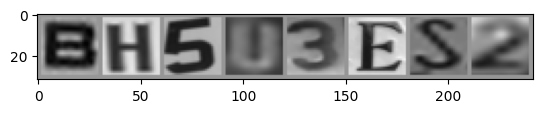

B     H     5     U     3     E     S     2    


In [17]:
# get some random training images and print them
dataiter = iter(dataloaders['train'])
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]), stats)
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

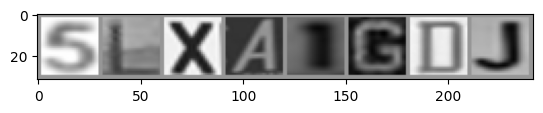

5     L     X     A     1     G     D     J    


In [18]:
# get some random val images and print them (shuffle set to False)
dataiter = iter(dataloaders['val'])
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]), stats)
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

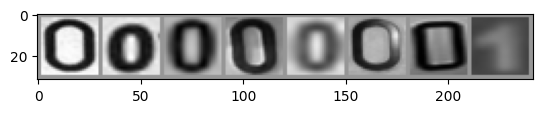

0     0     0     0     0     0     0     1    


In [19]:
# get some test images and print them (shuffle set to False)
dataiter = iter(dataloaders['test'])
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]), stats)
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

## Prepare transfer learning on new model

In [20]:
# Initialize model
model = Net(num_classes).to(device)

# Load pretrained weights
pretrained_dict = torch.load(PATH)
model_dict = model.state_dict()

# Filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# Overwrite entries in the existing state dict
model_dict.update(pretrained_dict)
# Load the new state dict
model.load_state_dict(model_dict)

# Freeze all layers except the final one
for name, param in model.named_parameters():
    if not name.startswith('fc2'):  # Only train the final fully connected layer
        param.requires_grad = False

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc2.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)
early_stopper = EarlyStopper(patience=early_stopping_patience, min_improve=min_improve)

Defining helper functions:

In [21]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=1000, fine_tune=False):
    best_acc = 0.0
    best_loss = float('inf')
    early_stopping_patience = 10
    
    if fine_tune:
        print("\nStarting fine-tuning of all layers...")
        # Unfreeze all layers for fine-tuning
        for param in model.parameters():
            param.requires_grad = True
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        epoch_losses = {"train": 0.0, "val": 0.0}
        epoch_accs = {"train": 0.0, "val": 0.0}
        
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Use tqdm for progress bar
            phase_loader = tqdm(dataloaders[phase], desc=f"{phase} phase", leave=False)
            for inputs, labels in phase_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Update progress bar
                phase_loader.set_postfix({
                    "loss": f"{loss.item():.4f}",
                    "acc": f"{torch.sum(preds == labels.data).item()/inputs.size(0):.4f}"
                })

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            epoch_losses[phase] = epoch_loss
            epoch_accs[phase] = epoch_acc
            
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            
            if phase == "val":
                if early_stopper(epoch_loss):
                    print(f"Early stopping triggered! Best val: {early_stopper.best_val:.4f}")
                    return model
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), TL_PATH)
                # Step the LR scheduler based on validation loss
                scheduler.step(epoch_loss)

    print(f"\nBest val Acc: {early_stopper.best_val:.4f}")
    return model


# Test function
def test_model(model, dataloader, model_path=None):
    if model_path:
        model.load_state_dict(torch.load(model_path))
    model.eval()
    
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        test_loop = tqdm(dataloader, desc="Testing", leave=False)
        for inputs, labels in test_loop:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            test_loop.set_postfix({
                "batch_acc": f"{torch.sum(preds == labels).item()/labels.size(0):.4f}"
            })
    
    accuracy = 100 * correct / total
    print(f"\nTest Accuracy: {accuracy:.2f}%")
    print(f"Correct: {correct}/{total}")
    
    return all_preds, all_labels

## Perform step 1 of transfer learning (frozen output FNN layer)

In [22]:
# Train the model
model = train_model(model, dataloaders, criterion, optimizer, num_epochs=nepochs)


Epoch 1/1000


train Loss: 3.2200 Acc: 0.6312


val Loss: 3.5183 Acc: 0.6140
New best value: 3.5183 (improvement > 0.010)

Epoch 2/1000


train Loss: 3.1011 Acc: 0.6454


val Loss: 3.3528 Acc: 0.6228
New best value: 3.3528 (improvement > 0.010)

Epoch 3/1000


train Loss: 2.9367 Acc: 0.6630


val Loss: 3.2010 Acc: 0.6404
New best value: 3.2010 (improvement > 0.010)

Epoch 4/1000


train Loss: 2.7974 Acc: 0.6718


val Loss: 3.0748 Acc: 0.6404
New best value: 3.0748 (improvement > 0.010)

Epoch 5/1000


train Loss: 2.7002 Acc: 0.6784


val Loss: 2.9586 Acc: 0.6184
New best value: 2.9586 (improvement > 0.010)

Epoch 6/1000


train Loss: 2.6201 Acc: 0.6652


val Loss: 2.8548 Acc: 0.6053
New best value: 2.8548 (improvement > 0.010)

Epoch 7/1000


train Loss: 2.5400 Acc: 0.6509


val Loss: 2.7715 Acc: 0.6009
New best value: 2.7715 (improvement > 0.010)

Epoch 8/1000


train Loss: 2.4528 Acc: 0.6465


val Loss: 2.6952 Acc: 0.6009
New best value: 2.6952 (improvement > 0.010)

Epoch 9/1000


train Loss: 2.3534 Acc: 0.6454


val Loss: 2.6178 Acc: 0.6053
New best value: 2.6178 (improvement > 0.010)

Epoch 10/1000


train Loss: 2.2517 Acc: 0.6553


val Loss: 2.5454 Acc: 0.6316
New best value: 2.5454 (improvement > 0.010)

Epoch 11/1000


train Loss: 2.1566 Acc: 0.6652


val Loss: 2.4809 Acc: 0.6535
New best value: 2.4809 (improvement > 0.010)

Epoch 12/1000


train Loss: 2.0608 Acc: 0.6784


val Loss: 2.4280 Acc: 0.6623
New best value: 2.4280 (improvement > 0.010)

Epoch 13/1000


train Loss: 1.9658 Acc: 0.6937


val Loss: 2.3975 Acc: 0.6579
New best value: 2.3975 (improvement > 0.010)

Epoch 14/1000


train Loss: 1.8901 Acc: 0.7058


val Loss: 2.3753 Acc: 0.6491
New best value: 2.3753 (improvement > 0.010)

Epoch 15/1000


train Loss: 1.8313 Acc: 0.7102


val Loss: 2.3256 Acc: 0.6447
New best value: 2.3256 (improvement > 0.010)

Epoch 16/1000


train Loss: 1.7621 Acc: 0.7102


val Loss: 2.2572 Acc: 0.6535
New best value: 2.2572 (improvement > 0.010)

Epoch 17/1000


train Loss: 1.6901 Acc: 0.7190


val Loss: 2.1960 Acc: 0.6667
New best value: 2.1960 (improvement > 0.010)

Epoch 18/1000


train Loss: 1.6311 Acc: 0.7256


val Loss: 2.1457 Acc: 0.6623
New best value: 2.1457 (improvement > 0.010)

Epoch 19/1000


train Loss: 1.5798 Acc: 0.7278


val Loss: 2.1001 Acc: 0.6754
New best value: 2.1001 (improvement > 0.010)

Epoch 20/1000


train Loss: 1.5271 Acc: 0.7333


val Loss: 2.0586 Acc: 0.6711
New best value: 2.0586 (improvement > 0.010)

Epoch 21/1000


train Loss: 1.4741 Acc: 0.7366


val Loss: 2.0281 Acc: 0.6667
New best value: 2.0281 (improvement > 0.010)

Epoch 22/1000


train Loss: 1.4296 Acc: 0.7431


val Loss: 2.0094 Acc: 0.6579
New best value: 2.0094 (improvement > 0.010)

Epoch 23/1000


train Loss: 1.3949 Acc: 0.7409


val Loss: 1.9925 Acc: 0.6535
New best value: 1.9925 (improvement > 0.010)

Epoch 24/1000


train Loss: 1.3601 Acc: 0.7420


val Loss: 1.9740 Acc: 0.6667
New best value: 1.9740 (improvement > 0.010)

Epoch 25/1000


train Loss: 1.3211 Acc: 0.7519


val Loss: 1.9578 Acc: 0.6754
New best value: 1.9578 (improvement > 0.010)

Epoch 26/1000


train Loss: 1.2821 Acc: 0.7585


val Loss: 1.9430 Acc: 0.6754
New best value: 1.9430 (improvement > 0.010)

Epoch 27/1000


train Loss: 1.2465 Acc: 0.7640


val Loss: 1.9257 Acc: 0.6798
New best value: 1.9257 (improvement > 0.010)

Epoch 28/1000


train Loss: 1.2155 Acc: 0.7684


val Loss: 1.9030 Acc: 0.6842
New best value: 1.9030 (improvement > 0.010)

Epoch 29/1000


train Loss: 1.1873 Acc: 0.7684


val Loss: 1.8749 Acc: 0.6886
New best value: 1.8749 (improvement > 0.010)

Epoch 30/1000


train Loss: 1.1597 Acc: 0.7728


val Loss: 1.8458 Acc: 0.7061
New best value: 1.8458 (improvement > 0.010)

Epoch 31/1000


train Loss: 1.1325 Acc: 0.7772


val Loss: 1.8203 Acc: 0.7018
New best value: 1.8203 (improvement > 0.010)

Epoch 32/1000


train Loss: 1.1075 Acc: 0.7849


val Loss: 1.8006 Acc: 0.7105
New best value: 1.8006 (improvement > 0.010)

Epoch 33/1000


train Loss: 1.0849 Acc: 0.7816


val Loss: 1.7867 Acc: 0.7105
New best value: 1.7867 (improvement > 0.010)

Epoch 34/1000


train Loss: 1.0638 Acc: 0.7892


val Loss: 1.7769 Acc: 0.7105
No improvement (1/10)

Epoch 35/1000


train Loss: 1.0429 Acc: 0.7936


val Loss: 1.7682 Acc: 0.7193
New best value: 1.7682 (improvement > 0.010)

Epoch 36/1000


train Loss: 1.0215 Acc: 0.7958


val Loss: 1.7591 Acc: 0.7281
No improvement (1/10)

Epoch 37/1000


train Loss: 1.0006 Acc: 0.7991


val Loss: 1.7499 Acc: 0.7325
New best value: 1.7499 (improvement > 0.010)

Epoch 38/1000


train Loss: 0.9817 Acc: 0.8035


val Loss: 1.7402 Acc: 0.7368
No improvement (1/10)

Epoch 39/1000


train Loss: 0.9647 Acc: 0.8079


val Loss: 1.7291 Acc: 0.7325
New best value: 1.7291 (improvement > 0.010)

Epoch 40/1000


train Loss: 0.9487 Acc: 0.8079


val Loss: 1.7168 Acc: 0.7368
New best value: 1.7168 (improvement > 0.010)

Epoch 41/1000


train Loss: 0.9328 Acc: 0.8068


val Loss: 1.7041 Acc: 0.7325
New best value: 1.7041 (improvement > 0.010)

Epoch 42/1000


train Loss: 0.9173 Acc: 0.8101


val Loss: 1.6916 Acc: 0.7412
New best value: 1.6916 (improvement > 0.010)

Epoch 43/1000


train Loss: 0.9025 Acc: 0.8123


val Loss: 1.6791 Acc: 0.7456
New best value: 1.6791 (improvement > 0.010)

Epoch 44/1000


train Loss: 0.8885 Acc: 0.8211


val Loss: 1.6664 Acc: 0.7368
New best value: 1.6664 (improvement > 0.010)

Epoch 45/1000


train Loss: 0.8751 Acc: 0.8211


val Loss: 1.6541 Acc: 0.7456
New best value: 1.6541 (improvement > 0.010)

Epoch 46/1000


train Loss: 0.8624 Acc: 0.8200


val Loss: 1.6436 Acc: 0.7500
New best value: 1.6436 (improvement > 0.010)

Epoch 47/1000


train Loss: 0.8502 Acc: 0.8222


val Loss: 1.6356 Acc: 0.7500
No improvement (1/10)

Epoch 48/1000


train Loss: 0.8384 Acc: 0.8288


val Loss: 1.6305 Acc: 0.7412
New best value: 1.6305 (improvement > 0.010)

Epoch 49/1000


train Loss: 0.8269 Acc: 0.8321


val Loss: 1.6278 Acc: 0.7325
No improvement (1/10)

Epoch 50/1000


train Loss: 0.8155 Acc: 0.8353


val Loss: 1.6267 Acc: 0.7368
No improvement (2/10)

Epoch 51/1000


train Loss: 0.8046 Acc: 0.8342


val Loss: 1.6258 Acc: 0.7325
No improvement (3/10)

Epoch 52/1000


train Loss: 0.7941 Acc: 0.8364


val Loss: 1.6237 Acc: 0.7325
No improvement (4/10)

Epoch 53/1000


train Loss: 0.7840 Acc: 0.8408


val Loss: 1.6193 Acc: 0.7281
New best value: 1.6193 (improvement > 0.010)

Epoch 54/1000


train Loss: 0.7742 Acc: 0.8430


val Loss: 1.6122 Acc: 0.7325
No improvement (1/10)

Epoch 55/1000


train Loss: 0.7647 Acc: 0.8419


val Loss: 1.6032 Acc: 0.7325
New best value: 1.6032 (improvement > 0.010)

Epoch 56/1000


train Loss: 0.7556 Acc: 0.8386


val Loss: 1.5933 Acc: 0.7325
No improvement (1/10)

Epoch 57/1000


train Loss: 0.7469 Acc: 0.8375


val Loss: 1.5837 Acc: 0.7368
New best value: 1.5837 (improvement > 0.010)

Epoch 58/1000


train Loss: 0.7385 Acc: 0.8408


val Loss: 1.5755 Acc: 0.7325
No improvement (1/10)

Epoch 59/1000


train Loss: 0.7304 Acc: 0.8463


val Loss: 1.5690 Acc: 0.7325
New best value: 1.5690 (improvement > 0.010)

Epoch 60/1000


train Loss: 0.7224 Acc: 0.8485


val Loss: 1.5642 Acc: 0.7412
No improvement (1/10)

Epoch 61/1000


train Loss: 0.7147 Acc: 0.8518


val Loss: 1.5603 Acc: 0.7412
No improvement (2/10)

Epoch 62/1000


train Loss: 0.7072 Acc: 0.8529


val Loss: 1.5566 Acc: 0.7325
New best value: 1.5566 (improvement > 0.010)

Epoch 63/1000


train Loss: 0.7000 Acc: 0.8562


val Loss: 1.5523 Acc: 0.7368
No improvement (1/10)

Epoch 64/1000


train Loss: 0.6928 Acc: 0.8562


val Loss: 1.5471 Acc: 0.7412
No improvement (2/10)

Epoch 65/1000


train Loss: 0.6859 Acc: 0.8595


val Loss: 1.5415 Acc: 0.7368
New best value: 1.5415 (improvement > 0.010)

Epoch 66/1000


train Loss: 0.6792 Acc: 0.8584


val Loss: 1.5358 Acc: 0.7368
No improvement (1/10)

Epoch 67/1000


train Loss: 0.6727 Acc: 0.8606


val Loss: 1.5305 Acc: 0.7368
New best value: 1.5305 (improvement > 0.010)

Epoch 68/1000


train Loss: 0.6663 Acc: 0.8639


val Loss: 1.5258 Acc: 0.7368
No improvement (1/10)

Epoch 69/1000


train Loss: 0.6601 Acc: 0.8650


val Loss: 1.5217 Acc: 0.7368
No improvement (2/10)

Epoch 70/1000


train Loss: 0.6539 Acc: 0.8672


val Loss: 1.5179 Acc: 0.7412
New best value: 1.5179 (improvement > 0.010)

Epoch 71/1000


train Loss: 0.6479 Acc: 0.8683


val Loss: 1.5141 Acc: 0.7500
No improvement (1/10)

Epoch 72/1000


train Loss: 0.6421 Acc: 0.8694


val Loss: 1.5100 Acc: 0.7500
No improvement (2/10)

Epoch 73/1000


train Loss: 0.6364 Acc: 0.8683


val Loss: 1.5056 Acc: 0.7456
New best value: 1.5056 (improvement > 0.010)

Epoch 74/1000


train Loss: 0.6309 Acc: 0.8694


val Loss: 1.5010 Acc: 0.7456
No improvement (1/10)

Epoch 75/1000


train Loss: 0.6255 Acc: 0.8694


val Loss: 1.4967 Acc: 0.7456
No improvement (2/10)

Epoch 76/1000


train Loss: 0.6202 Acc: 0.8727


val Loss: 1.4928 Acc: 0.7412
New best value: 1.4928 (improvement > 0.010)

Epoch 77/1000


train Loss: 0.6151 Acc: 0.8738


val Loss: 1.4895 Acc: 0.7412
No improvement (1/10)

Epoch 78/1000


train Loss: 0.6100 Acc: 0.8760


val Loss: 1.4868 Acc: 0.7412
No improvement (2/10)

Epoch 79/1000


train Loss: 0.6050 Acc: 0.8771


val Loss: 1.4844 Acc: 0.7412
No improvement (3/10)

Epoch 80/1000


train Loss: 0.6002 Acc: 0.8814


val Loss: 1.4821 Acc: 0.7412
New best value: 1.4821 (improvement > 0.010)

Epoch 81/1000


train Loss: 0.5954 Acc: 0.8825


val Loss: 1.4794 Acc: 0.7412
No improvement (1/10)

Epoch 82/1000


train Loss: 0.5908 Acc: 0.8825


val Loss: 1.4763 Acc: 0.7412
No improvement (2/10)

Epoch 83/1000


train Loss: 0.5862 Acc: 0.8825


val Loss: 1.4729 Acc: 0.7368
No improvement (3/10)

Epoch 84/1000


train Loss: 0.5818 Acc: 0.8825


val Loss: 1.4693 Acc: 0.7368
New best value: 1.4693 (improvement > 0.010)

Epoch 85/1000


train Loss: 0.5774 Acc: 0.8836


val Loss: 1.4658 Acc: 0.7368
No improvement (1/10)

Epoch 86/1000


train Loss: 0.5731 Acc: 0.8836


val Loss: 1.4625 Acc: 0.7368
No improvement (2/10)

Epoch 87/1000


train Loss: 0.5689 Acc: 0.8836


val Loss: 1.4594 Acc: 0.7368
No improvement (3/10)

Epoch 88/1000


train Loss: 0.5647 Acc: 0.8836


val Loss: 1.4565 Acc: 0.7368
New best value: 1.4565 (improvement > 0.010)

Epoch 89/1000


train Loss: 0.5606 Acc: 0.8847


val Loss: 1.4536 Acc: 0.7368
No improvement (1/10)

Epoch 90/1000


train Loss: 0.5567 Acc: 0.8847


val Loss: 1.4506 Acc: 0.7368
No improvement (2/10)

Epoch 91/1000


train Loss: 0.5528 Acc: 0.8847


val Loss: 1.4475 Acc: 0.7368
No improvement (3/10)

Epoch 92/1000


train Loss: 0.5489 Acc: 0.8869


val Loss: 1.4443 Acc: 0.7412
New best value: 1.4443 (improvement > 0.010)

Epoch 93/1000


train Loss: 0.5452 Acc: 0.8891


val Loss: 1.4410 Acc: 0.7412
No improvement (1/10)

Epoch 94/1000


train Loss: 0.5415 Acc: 0.8891


val Loss: 1.4378 Acc: 0.7412
No improvement (2/10)

Epoch 95/1000


train Loss: 0.5379 Acc: 0.8902


val Loss: 1.4348 Acc: 0.7412
No improvement (3/10)

Epoch 96/1000


train Loss: 0.5343 Acc: 0.8935


val Loss: 1.4320 Acc: 0.7412
New best value: 1.4320 (improvement > 0.010)

Epoch 97/1000


train Loss: 0.5308 Acc: 0.8946


val Loss: 1.4294 Acc: 0.7412
No improvement (1/10)

Epoch 98/1000


train Loss: 0.5274 Acc: 0.8946


val Loss: 1.4269 Acc: 0.7412
No improvement (2/10)

Epoch 99/1000


train Loss: 0.5240 Acc: 0.8946


val Loss: 1.4245 Acc: 0.7412
No improvement (3/10)

Epoch 100/1000


train Loss: 0.5207 Acc: 0.8935


val Loss: 1.4220 Acc: 0.7412
No improvement (4/10)

Epoch 101/1000


train Loss: 0.5175 Acc: 0.8946


val Loss: 1.4196 Acc: 0.7412
New best value: 1.4196 (improvement > 0.010)

Epoch 102/1000


train Loss: 0.5143 Acc: 0.8957


val Loss: 1.4171 Acc: 0.7368
No improvement (1/10)

Epoch 103/1000


train Loss: 0.5111 Acc: 0.8990


val Loss: 1.4147 Acc: 0.7368
No improvement (2/10)

Epoch 104/1000


train Loss: 0.5080 Acc: 0.9012


val Loss: 1.4124 Acc: 0.7368
No improvement (3/10)

Epoch 105/1000


train Loss: 0.5050 Acc: 0.9023


val Loss: 1.4102 Acc: 0.7368
No improvement (4/10)

Epoch 106/1000


train Loss: 0.5020 Acc: 0.9023


val Loss: 1.4082 Acc: 0.7325
New best value: 1.4082 (improvement > 0.010)

Epoch 107/1000


train Loss: 0.4990 Acc: 0.9023


val Loss: 1.4062 Acc: 0.7325
No improvement (1/10)

Epoch 108/1000


train Loss: 0.4961 Acc: 0.9023


val Loss: 1.4042 Acc: 0.7325
No improvement (2/10)

Epoch 109/1000


train Loss: 0.4932 Acc: 0.9023


val Loss: 1.4023 Acc: 0.7325
No improvement (3/10)

Epoch 110/1000


train Loss: 0.4904 Acc: 0.9045


val Loss: 1.4003 Acc: 0.7325
No improvement (4/10)

Epoch 111/1000


train Loss: 0.4876 Acc: 0.9067


val Loss: 1.3984 Acc: 0.7325
No improvement (5/10)

Epoch 112/1000


train Loss: 0.4849 Acc: 0.9100


val Loss: 1.3965 Acc: 0.7325
New best value: 1.3965 (improvement > 0.010)

Epoch 113/1000


train Loss: 0.4821 Acc: 0.9100


val Loss: 1.3947 Acc: 0.7325
No improvement (1/10)

Epoch 114/1000


train Loss: 0.4795 Acc: 0.9111


val Loss: 1.3930 Acc: 0.7325
No improvement (2/10)

Epoch 115/1000


train Loss: 0.4768 Acc: 0.9111


val Loss: 1.3913 Acc: 0.7325
No improvement (3/10)

Epoch 116/1000


train Loss: 0.4743 Acc: 0.9122


val Loss: 1.3897 Acc: 0.7325
No improvement (4/10)

Epoch 117/1000


train Loss: 0.4717 Acc: 0.9122


val Loss: 1.3881 Acc: 0.7325
No improvement (5/10)

Epoch 118/1000


train Loss: 0.4692 Acc: 0.9122


val Loss: 1.3866 Acc: 0.7325
No improvement (6/10)

Epoch 119/1000


train Loss: 0.4667 Acc: 0.9133


val Loss: 1.3850 Acc: 0.7325
New best value: 1.3850 (improvement > 0.010)

Epoch 120/1000


train Loss: 0.4642 Acc: 0.9144


val Loss: 1.3834 Acc: 0.7325
No improvement (1/10)

Epoch 121/1000


train Loss: 0.4618 Acc: 0.9144


val Loss: 1.3819 Acc: 0.7368
No improvement (2/10)

Epoch 122/1000


train Loss: 0.4594 Acc: 0.9144


val Loss: 1.3803 Acc: 0.7368
No improvement (3/10)

Epoch 123/1000


train Loss: 0.4571 Acc: 0.9155


val Loss: 1.3789 Acc: 0.7368
No improvement (4/10)

Epoch 124/1000


train Loss: 0.4547 Acc: 0.9155


val Loss: 1.3774 Acc: 0.7368
No improvement (5/10)

Epoch 125/1000


train Loss: 0.4524 Acc: 0.9155


val Loss: 1.3760 Acc: 0.7368
No improvement (6/10)

Epoch 126/1000


train Loss: 0.4502 Acc: 0.9155


val Loss: 1.3746 Acc: 0.7368
New best value: 1.3746 (improvement > 0.010)

Epoch 127/1000


train Loss: 0.4479 Acc: 0.9177


val Loss: 1.3733 Acc: 0.7368
No improvement (1/10)

Epoch 128/1000


train Loss: 0.4457 Acc: 0.9177


val Loss: 1.3720 Acc: 0.7368
No improvement (2/10)

Epoch 129/1000


train Loss: 0.4435 Acc: 0.9177


val Loss: 1.3708 Acc: 0.7368
No improvement (3/10)

Epoch 130/1000


train Loss: 0.4414 Acc: 0.9188


val Loss: 1.3696 Acc: 0.7368
No improvement (4/10)

Epoch 131/1000


train Loss: 0.4392 Acc: 0.9188


val Loss: 1.3684 Acc: 0.7368
No improvement (5/10)

Epoch 132/1000


train Loss: 0.4371 Acc: 0.9199


val Loss: 1.3672 Acc: 0.7368
No improvement (6/10)

Epoch 133/1000


train Loss: 0.4350 Acc: 0.9221


val Loss: 1.3661 Acc: 0.7368
No improvement (7/10)

Epoch 134/1000


train Loss: 0.4330 Acc: 0.9221


val Loss: 1.3650 Acc: 0.7368
No improvement (8/10)

Epoch 135/1000


train Loss: 0.4309 Acc: 0.9221


val Loss: 1.3638 Acc: 0.7368
New best value: 1.3638 (improvement > 0.010)

Epoch 136/1000


train Loss: 0.4289 Acc: 0.9221


val Loss: 1.3627 Acc: 0.7368
No improvement (1/10)

Epoch 137/1000


train Loss: 0.4269 Acc: 0.9221


val Loss: 1.3616 Acc: 0.7368
No improvement (2/10)

Epoch 138/1000


train Loss: 0.4250 Acc: 0.9221


val Loss: 1.3605 Acc: 0.7368
No improvement (3/10)

Epoch 139/1000


train Loss: 0.4230 Acc: 0.9232


val Loss: 1.3594 Acc: 0.7368
No improvement (4/10)

Epoch 140/1000


train Loss: 0.4211 Acc: 0.9232


val Loss: 1.3584 Acc: 0.7368
No improvement (5/10)

Epoch 141/1000


train Loss: 0.4192 Acc: 0.9232


val Loss: 1.3574 Acc: 0.7368
No improvement (6/10)

Epoch 142/1000


train Loss: 0.4173 Acc: 0.9232


val Loss: 1.3565 Acc: 0.7368
No improvement (7/10)

Epoch 143/1000


train Loss: 0.4155 Acc: 0.9243


val Loss: 1.3555 Acc: 0.7368
No improvement (8/10)

Epoch 144/1000


train Loss: 0.4136 Acc: 0.9243


val Loss: 1.3547 Acc: 0.7368
No improvement (9/10)

Epoch 145/1000


train Loss: 0.4118 Acc: 0.9243


val Loss: 1.3538 Acc: 0.7412
New best value: 1.3538 (improvement > 0.010)

Epoch 146/1000


train Loss: 0.4100 Acc: 0.9254


val Loss: 1.3529 Acc: 0.7412
No improvement (1/10)

Epoch 147/1000


train Loss: 0.4082 Acc: 0.9265


val Loss: 1.3520 Acc: 0.7412
No improvement (2/10)

Epoch 148/1000


train Loss: 0.4065 Acc: 0.9265


val Loss: 1.3512 Acc: 0.7412
No improvement (3/10)

Epoch 149/1000


train Loss: 0.4047 Acc: 0.9265


val Loss: 1.3504 Acc: 0.7412
No improvement (4/10)

Epoch 150/1000


train Loss: 0.4030 Acc: 0.9265


val Loss: 1.3496 Acc: 0.7456
No improvement (5/10)

Epoch 151/1000


train Loss: 0.4013 Acc: 0.9265


val Loss: 1.3488 Acc: 0.7456
No improvement (6/10)

Epoch 152/1000


train Loss: 0.3996 Acc: 0.9265


val Loss: 1.3480 Acc: 0.7500
No improvement (7/10)

Epoch 153/1000


train Loss: 0.3979 Acc: 0.9265


val Loss: 1.3472 Acc: 0.7500
No improvement (8/10)

Epoch 154/1000


train Loss: 0.3962 Acc: 0.9265


val Loss: 1.3464 Acc: 0.7500
No improvement (9/10)

Epoch 155/1000


train Loss: 0.3946 Acc: 0.9265


val Loss: 1.3457 Acc: 0.7500
No improvement (10/10)
Early stopping triggered! Best val: 1.3538



Test Accuracy: 70.75%
Correct: 75/106


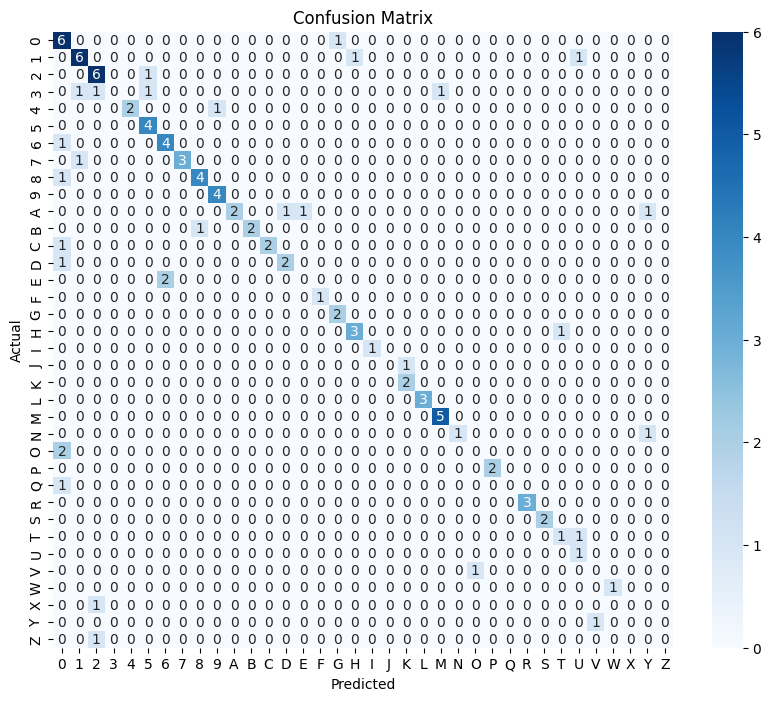

In [23]:
model.load_state_dict(torch.load(TL_PATH))

# Evaluate the model on the test set
preds, labels = test_model(model, dataloaders["test"])

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Perform step 2 of transfer learning (unfreeze and train all layers with a small learning rate)


Starting fine-tuning of all layers...

Epoch 1/1000


train Loss: 0.4004 Acc: 0.8968


val Loss: 1.5599 Acc: 0.7105
New best value: 1.5599 (improvement > 0.010)

Epoch 2/1000


train Loss: 0.3999 Acc: 0.8968


val Loss: 1.5586 Acc: 0.7105
No improvement (1/10)

Epoch 3/1000


train Loss: 0.3990 Acc: 0.8968


val Loss: 1.5567 Acc: 0.7105
No improvement (2/10)

Epoch 4/1000


train Loss: 0.3978 Acc: 0.8990


val Loss: 1.5543 Acc: 0.7105
No improvement (3/10)

Epoch 5/1000


train Loss: 0.3963 Acc: 0.9012


val Loss: 1.5516 Acc: 0.7105
No improvement (4/10)

Epoch 6/1000


train Loss: 0.3945 Acc: 0.9023


val Loss: 1.5487 Acc: 0.7105
New best value: 1.5487 (improvement > 0.010)

Epoch 7/1000


train Loss: 0.3926 Acc: 0.9023


val Loss: 1.5455 Acc: 0.7149
No improvement (1/10)

Epoch 8/1000


train Loss: 0.3906 Acc: 0.9034


val Loss: 1.5422 Acc: 0.7149
No improvement (2/10)

Epoch 9/1000


train Loss: 0.3884 Acc: 0.9045


val Loss: 1.5389 Acc: 0.7149
No improvement (3/10)

Epoch 10/1000


train Loss: 0.3863 Acc: 0.9045


val Loss: 1.5356 Acc: 0.7149
New best value: 1.5356 (improvement > 0.010)

Epoch 11/1000


train Loss: 0.3841 Acc: 0.9056


val Loss: 1.5324 Acc: 0.7149
No improvement (1/10)

Epoch 12/1000


train Loss: 0.3819 Acc: 0.9089


val Loss: 1.5293 Acc: 0.7105
No improvement (2/10)

Epoch 13/1000


train Loss: 0.3798 Acc: 0.9078


val Loss: 1.5263 Acc: 0.7105
No improvement (3/10)

Epoch 14/1000


train Loss: 0.3776 Acc: 0.9100


val Loss: 1.5234 Acc: 0.7105
New best value: 1.5234 (improvement > 0.010)

Epoch 15/1000


train Loss: 0.3756 Acc: 0.9100


val Loss: 1.5207 Acc: 0.7105
No improvement (1/10)

Epoch 16/1000


train Loss: 0.3736 Acc: 0.9111


val Loss: 1.5181 Acc: 0.7105
No improvement (2/10)

Epoch 17/1000


train Loss: 0.3716 Acc: 0.9122


val Loss: 1.5157 Acc: 0.7105
No improvement (3/10)

Epoch 18/1000


train Loss: 0.3698 Acc: 0.9122


val Loss: 1.5134 Acc: 0.7105
New best value: 1.5134 (improvement > 0.010)

Epoch 19/1000


train Loss: 0.3680 Acc: 0.9155


val Loss: 1.5113 Acc: 0.7105
No improvement (1/10)

Epoch 20/1000


train Loss: 0.3662 Acc: 0.9166


val Loss: 1.5093 Acc: 0.7105
No improvement (2/10)

Epoch 21/1000


train Loss: 0.3645 Acc: 0.9188


val Loss: 1.5075 Acc: 0.7105
No improvement (3/10)

Epoch 22/1000


train Loss: 0.3629 Acc: 0.9188


val Loss: 1.5058 Acc: 0.7105
No improvement (4/10)

Epoch 23/1000


train Loss: 0.3613 Acc: 0.9221


val Loss: 1.5042 Acc: 0.7061
No improvement (5/10)

Epoch 24/1000


train Loss: 0.3598 Acc: 0.9221


val Loss: 1.5027 Acc: 0.7105
New best value: 1.5027 (improvement > 0.010)

Epoch 25/1000


train Loss: 0.3583 Acc: 0.9232


val Loss: 1.5013 Acc: 0.7105
No improvement (1/10)

Epoch 26/1000


train Loss: 0.3569 Acc: 0.9254


val Loss: 1.5000 Acc: 0.7105
No improvement (2/10)

Epoch 27/1000


train Loss: 0.3556 Acc: 0.9265


val Loss: 1.4987 Acc: 0.7105
No improvement (3/10)

Epoch 28/1000


train Loss: 0.3542 Acc: 0.9286


val Loss: 1.4976 Acc: 0.7105
No improvement (4/10)

Epoch 29/1000


train Loss: 0.3529 Acc: 0.9297


val Loss: 1.4965 Acc: 0.7149
No improvement (5/10)

Epoch 30/1000


train Loss: 0.3517 Acc: 0.9297


val Loss: 1.4955 Acc: 0.7149
No improvement (6/10)

Epoch 31/1000


train Loss: 0.3505 Acc: 0.9297


val Loss: 1.4946 Acc: 0.7149
No improvement (7/10)

Epoch 32/1000


train Loss: 0.3493 Acc: 0.9297


val Loss: 1.4936 Acc: 0.7149
No improvement (8/10)

Epoch 33/1000


train Loss: 0.3482 Acc: 0.9297


val Loss: 1.4928 Acc: 0.7149
No improvement (9/10)

Epoch 34/1000


train Loss: 0.3471 Acc: 0.9297


val Loss: 1.4919 Acc: 0.7193
New best value: 1.4919 (improvement > 0.010)

Epoch 35/1000


train Loss: 0.3461 Acc: 0.9297


val Loss: 1.4911 Acc: 0.7193
No improvement (1/10)

Epoch 36/1000


train Loss: 0.3450 Acc: 0.9286


val Loss: 1.4903 Acc: 0.7193
No improvement (2/10)

Epoch 37/1000


train Loss: 0.3440 Acc: 0.9297


val Loss: 1.4895 Acc: 0.7193
No improvement (3/10)

Epoch 38/1000


train Loss: 0.3430 Acc: 0.9297


val Loss: 1.4887 Acc: 0.7193
No improvement (4/10)

Epoch 39/1000


train Loss: 0.3421 Acc: 0.9297


val Loss: 1.4880 Acc: 0.7237
No improvement (5/10)

Epoch 40/1000


train Loss: 0.3411 Acc: 0.9297


val Loss: 1.4872 Acc: 0.7237
No improvement (6/10)

Epoch 41/1000


train Loss: 0.3402 Acc: 0.9308


val Loss: 1.4865 Acc: 0.7237
No improvement (7/10)

Epoch 42/1000


train Loss: 0.3393 Acc: 0.9308


val Loss: 1.4858 Acc: 0.7237
No improvement (8/10)

Epoch 43/1000


train Loss: 0.3384 Acc: 0.9308


val Loss: 1.4852 Acc: 0.7281
No improvement (9/10)

Epoch 44/1000


train Loss: 0.3376 Acc: 0.9308


val Loss: 1.4845 Acc: 0.7281
No improvement (10/10)
Early stopping triggered! Best val: 1.4919

Final evaluation after fine-tuning:



Test Accuracy: 73.58%
Correct: 78/106


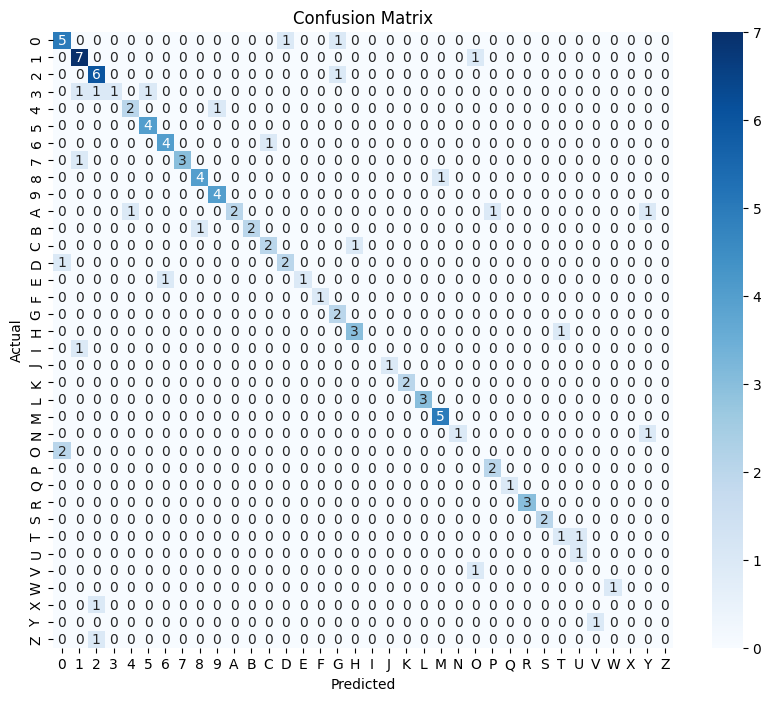

In [24]:
early_stopper = EarlyStopper(patience=early_stopping_patience, min_improve=min_improve)

# Initial transform for calculating stats
initial_transform = transforms.Compose([transforms.Resize((image_resize, image_resize), interpolation=InterpolationMode.BILINEAR),
                                        transforms.Grayscale(num_output_channels=1),
                                        transforms.ToTensor()])

# Load dataset for stats calculation
train_dataset_initial = torchvision.datasets.ImageFolder(root=tl_train_folder, transform=initial_transform)
train_loader_initial = torch.utils.data.DataLoader(train_dataset_initial, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Calculate stats
stats_license_place = get_dataset_stats(train_loader_initial)

# Define transforms with augmentation for training and simple resize for test
transform = {
    "train": transforms.Compose([
        transforms.Resize((image_resize, image_resize), interpolation=InterpolationMode.BILINEAR),
        # transforms.RandomCrop(image_resize),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
        # transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean=stats_license_place[0], std=stats_license_place[1])
    ]),
    "test": transforms.Compose([
        transforms.Resize((image_resize, image_resize)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((stats_license_place[0]), (stats_license_place[1]))])
}

# Load datasets with proper transforms
train_dataset = torchvision.datasets.ImageFolder(root=tl_train_folder, transform=transform["train"])
test_set = torchvision.datasets.ImageFolder(root=tl_test_folder, transform=transform["test"])

# Split train into train and validation
train_set_size = int(0.8 * len(train_dataset))
val_set_size = len(train_dataset) - train_set_size
train_set, val_set = torch.utils.data.random_split(train_dataset, [train_set_size, val_set_size], generator=torch.Generator().manual_seed(0))

# Create data loaders
dataloaders = {"train": torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True),
               "val": torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True),
               "test": torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)}

# Get classes
classes = train_dataset.classes
num_classes = len(classes)

# Fine-tuning (train all layers)
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
model = train_model(model, dataloaders, criterion, optimizer, num_epochs=nepochs, fine_tune=True)

# Final evaluation after fine-tuning
print("\nFinal evaluation after fine-tuning:")
all_preds, all_labels = test_model(model, dataloaders["test"], TL_PATH)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Do some more evaluations:

In [25]:
TL_PATH

'./best_license_plate_model.pth'

In [26]:
net = Net(num_classes)
net.load_state_dict(torch.load(TL_PATH))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07281762..1.2351727].


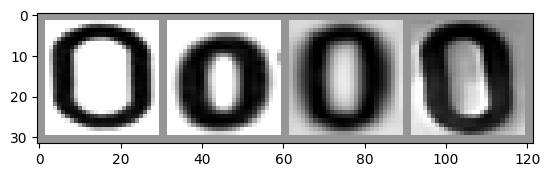

GroundTruth:  0     0     0     0    


In [27]:
dataiter = iter(dataloaders['test'])
images, labels = next(dataiter)
# print images
imshow(torchvision.utils.make_grid(images[:4]), stats)
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
outputs = net(images)

In [28]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  0     0     0     0    


In [35]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:2s} is {accuracy:.1f}%, Set size: {total_pred[classname]}')


Accuracy for class: 0  is 71.4%, Set size: 7
Accuracy for class: 1  is 87.5%, Set size: 8
Accuracy for class: 2  is 85.7%, Set size: 7
Accuracy for class: 3  is 25.0%, Set size: 4
Accuracy for class: 4  is 66.7%, Set size: 3
Accuracy for class: 5  is 100.0%, Set size: 4
Accuracy for class: 6  is 80.0%, Set size: 5
Accuracy for class: 7  is 75.0%, Set size: 4
Accuracy for class: 8  is 80.0%, Set size: 5
Accuracy for class: 9  is 100.0%, Set size: 4
Accuracy for class: A  is 40.0%, Set size: 5
Accuracy for class: B  is 66.7%, Set size: 3
Accuracy for class: C  is 66.7%, Set size: 3
Accuracy for class: D  is 66.7%, Set size: 3
Accuracy for class: E  is 50.0%, Set size: 2
Accuracy for class: F  is 100.0%, Set size: 1
Accuracy for class: G  is 100.0%, Set size: 2
Accuracy for class: H  is 75.0%, Set size: 4
Accuracy for class: I  is 0.0%, Set size: 1
Accuracy for class: J  is 100.0%, Set size: 1
Accuracy for class: K  is 100.0%, Set size: 2
Accuracy for class: L  is 100.0%, Set size: 3
Accu